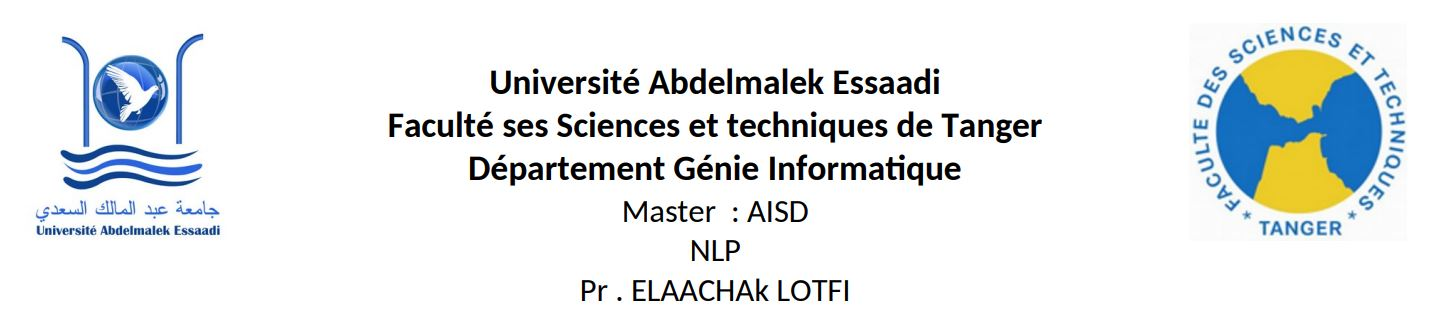

## LAB 2 .

## Objective : The main purpose behind this lab is to get familiar with NLP Rule based, Regex and NLP Word embedding.

## Author: AACHABI Mohammed - MST IASD

In [24]:
import pyarabic.araby as araby
from tashaphyne.stemming import ArabicLightStemmer
import string
import pymongo
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
import spacy
import qalsadi.lemmatizer as lem
from sklearn.preprocessing import OneHotEncoder
from gensim.models import FastText
from sklearn.manifold import TSNE

## load Data vectors collected during the lab 1.

In [25]:
client = pymongo.MongoClient('localhost', 27017)
db = client['nlp']
collection = db['aljazera']

# get content from MongoDB
cursor = collection.find({})
contents = ' '.join(doc['content'] for doc in cursor[:2])

In [26]:
print(contents)


صادق مجلس الحكومة، المنعقد اليوم الخميس برئاسة عزيز أخنوش، على مشروع القانون رقم 22.24 بتغيير وتتميم القانون رقم 47.18 المتعلق بإصلاح المراكز الجهوية للاستثمار وبإحداث اللجان الجهوية الموحدة للاستثمار، أخذاً بعين الاعتبار الملاحظات المثارة، قدمه محسن جازولي، الوزير المنتدب لدى رئيس الحكومة المكلف بالاستثمار والالتقائية وتقييم السياسات العمومية. وأوضحت رئاسة الحكومة، في بلاغ لها، أن هذا المشروع يندرج في إطار مواصلة إصلاح المراكز الجهوية للاستثمار تنفيذا للتوجيهات السامية للملك محمد السادس بمناسبة خطاب العرش بتاريخ 29 يوليوز 2018، إذ دعا الملك، من خلاله، إلى “تفعيل إصلاح المراكز الجهوية للاستثمار وتمكينها من الصلاحيات اللازمة للقيام بدورها”.


## Establishment of NLP Pipeline (Text Cleaning, Tokenization, Stop words, Discretization, Normalization).

In [27]:
import re

def clean_str(text):
    search = ["أ","إ","آ","ة","_","-","/",".","،"," و "," يا ",'"',"ـ","'","ى",'\n', '\t','"','?','؟','!']
    replace = ["ا","ا","ا","ه"," "," ","","",""," و"," يا","","","","ي","",' ', ' ',' ',' ? ',' ؟ ',' ! ']
    # remove HTML TAG
    html = re.compile('[<،,()"".#*?>]')
    text = html.sub(r'', text)
    
    # Remove urls:
    url = re.compile('https?://\S+|www\.S+')
    text = url.sub(r'', text)
    
    # Remove email id:
    email = re.compile('[A-Za-z0-2]+@[\w]+.[\w]+')
    text = email.sub(r'', text)
    
    # Remove tashkeel
    p_tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    text = re.sub(p_tashkeel, "", text)
    
    # Remove longation "EX : سلاممممم = سلامم"
    p_longation = re.compile(r'(.)\1+')
    subst = r"\1\1"
    text = re.sub(p_longation, subst, text)
    
    text = text.replace('وو', 'و')
    text = text.replace('يي', 'ي')
    text = text.replace('اا', 'ا')
    
    # Remove digits
    text = re.sub(r'\d+', '', text)
    
    for i in range(0, len(search)):
        text = text.replace(search[i], replace[i])
    
    # remove any leading and trailing whitespace characters    
    text = text.strip()
    return text


<>:11: SyntaxWarning: invalid escape sequence '\S'
<>:15: SyntaxWarning: invalid escape sequence '\w'
<>:11: SyntaxWarning: invalid escape sequence '\S'
<>:15: SyntaxWarning: invalid escape sequence '\w'
C:\Users\lenovo\AppData\Local\Temp\ipykernel_9900\2716230031.py:11: SyntaxWarning: invalid escape sequence '\S'
  url = re.compile('https?://\S+|www\.S+')
C:\Users\lenovo\AppData\Local\Temp\ipykernel_9900\2716230031.py:15: SyntaxWarning: invalid escape sequence '\w'
  email = re.compile('[A-Za-z0-2]+@[\w]+.[\w]+')


In [28]:
para = clean_str(contents)
print(para)

صادق مجلس الحكومه المنعقد اليوم الخميس برئاسه عزيز اخنوش علي مشروع القانون رقم  بتغير وتتميم القانون رقم  المتعلق باصلاح المراكز الجهويه للاستثمار وباحداث اللجان الجهويه الموحده للاستثمار اخذا بعين الاعتبار الملاحظات المثاره قدمه محسن جازولي الوزير المنتدب لدي رئيس الحكومه المكلف بالاستثمار والالتقائيه وتقيم السياسات العموميه واوضحت رئاسه الحكومه في بلاغ لها ان هذا المشروع يندرج في اطار مواصله اصلاح المراكز الجهويه للاستثمار تنفيذا للتوجيهات الساميه للملك محمد السادس بمناسبه خطاب العرش بتاريخ  يوليوز  اذ دعا الملك من خلاله الي “تفعيل اصلاح المراكز الجهويه للاستثمار وتمكينها من الصلاحيات اللازمه للقيام بدورها”


In [29]:

def tokenize(para):
 # Tokenize the text
 tokens = word_tokenize(para)

 # Filter tokens to keep only non-numeric ones
 filtered_tokens = [token for token in tokens if not token.isdigit()]

 # Regular expression pattern to match words starting with 'و'
 pattern = r'^و\w*'
    
 # Tokenize the words starting with 'و'
 custom_tokens = []
 for token in filtered_tokens:
    if re.match(pattern, token):
        custom_tokens.append('و')
        if len(token) > 1:
            custom_tokens.append(token[1:])
    else:
        custom_tokens.append(token)
 return custom_tokens


## *Tokenization*

In [30]:
custom_tokens = tokenize(para)

In [31]:
# Tokeniser les phrases
tokens_sentences = araby.sentence_tokenize(contents)

In [32]:
# Afficher les résultats
print(custom_tokens)
print('---------------------------')
print(tokens_sentences)


['صادق', 'مجلس', 'الحكومه', 'المنعقد', 'اليوم', 'الخميس', 'برئاسه', 'عزيز', 'اخنوش', 'علي', 'مشروع', 'القانون', 'رقم', 'بتغير', 'و', 'تتميم', 'القانون', 'رقم', 'المتعلق', 'باصلاح', 'المراكز', 'الجهويه', 'للاستثمار', 'و', 'باحداث', 'اللجان', 'الجهويه', 'الموحده', 'للاستثمار', 'اخذا', 'بعين', 'الاعتبار', 'الملاحظات', 'المثاره', 'قدمه', 'محسن', 'جازولي', 'الوزير', 'المنتدب', 'لدي', 'رئيس', 'الحكومه', 'المكلف', 'بالاستثمار', 'و', 'الالتقائيه', 'و', 'تقيم', 'السياسات', 'العموميه', 'و', 'اوضحت', 'رئاسه', 'الحكومه', 'في', 'بلاغ', 'لها', 'ان', 'هذا', 'المشروع', 'يندرج', 'في', 'اطار', 'مواصله', 'اصلاح', 'المراكز', 'الجهويه', 'للاستثمار', 'تنفيذا', 'للتوجيهات', 'الساميه', 'للملك', 'محمد', 'السادس', 'بمناسبه', 'خطاب', 'العرش', 'بتاريخ', 'يوليوز', 'اذ', 'دعا', 'الملك', 'من', 'خلاله', 'الي', '“', 'تفعيل', 'اصلاح', 'المراكز', 'الجهويه', 'للاستثمار', 'و', 'تمكينها', 'من', 'الصلاحيات', 'اللازمه', 'للقيام', 'بدورها', '”']
---------------------------
['صادق مجلس الحكومة،', 'المنعقد اليوم الخميس برئاسة ع

In [41]:
def stop_words(custom_tokens,tokens_sen):
     # Load Arabic stopwords
     stop_words = set(stopwords.words('arabic'))
     # Filter out stop words
     filtered_words = [token for token in custom_tokens if not token in stop_words]
     filtered_sen = [''.join([x for x in re.split(r'(\W+)', sent) if x not in stop_words]) for sent in tokens_sen]

     return filtered_words,filtered_sen

filtered_words,filtered_sen= stop_words(custom_tokens,tokens_sentences)
print("Filtered sen:")
print(filtered_sen)
print("\nFiltered Tokens:")
print(filtered_words)

Filtered sen:
['صادق مجلس الحكومة،', 'المنعقد اليوم الخميس برئاسة عزيز أخنوش،', ' مشروع القانون رقم 22.24 بتغيير وتتميم القانون رقم 47.18 المتعلق بإصلاح المراكز الجهوية للاستثمار وبإحداث اللجان الجهوية الموحدة للاستثمار،', 'أخذاً بعين الاعتبار الملاحظات المثارة،', 'قدمه محسن جازولي،', 'الوزير المنتدب  رئيس الحكومة المكلف بالاستثمار والالتقائية وتقييم السياسات العمومية.', 'وأوضحت رئاسة الحكومة،', ' بلاغ ،', '  المشروع يندرج  إطار مواصلة إصلاح المراكز الجهوية للاستثمار تنفيذا للتوجيهات السامية للملك محمد السادس بمناسبة خطاب العرش بتاريخ 29 يوليوز 2018،', ' دعا الملك،', ' خلاله،', ' “تفعيل إصلاح المراكز الجهوية للاستثمار وتمكينها  الصلاحيات اللازمة للقيام بدورها”.']

Filtered Tokens:
['صادق', 'مجلس', 'الحكومه', 'المنعقد', 'اليوم', 'الخميس', 'برئاسه', 'عزيز', 'اخنوش', 'علي', 'مشروع', 'القانون', 'رقم', 'بتغير', 'تتميم', 'القانون', 'رقم', 'المتعلق', 'باصلاح', 'المراكز', 'الجهويه', 'للاستثمار', 'باحداث', 'اللجان', 'الجهويه', 'الموحده', 'للاستثمار', 'اخذا', 'بعين', 'الاعتبار', 'الملاحظات', 'ال

In [43]:
ar_punct = ''')(+`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”،.”…“–ـ”.'''
en_punct = string.punctuation
punct_lst = ar_punct + en_punct

eng = string.punctuation
filtered_sen = [sent.translate(str.maketrans('', '', punct_lst)) for sent in filtered_sen]


In [44]:
lemmer = lem.Lemmatizer()
lemmas = [lemmer.lemmatize(token) for token in filtered_words]
print("Lemmatized token list : ", lemmas)

Lemmatized token list :  ['صادق', 'مجلس', 'الحكومه', 'منعقد', 'يوم', 'خميس', 'برئاسه', 'عزيز', 'اخنوش', 'علي', 'مشروع', 'قانون', 'رقم', 'تغير', 'تتميم', 'قانون', 'رقم', 'متعلق', 'باصلاح', 'مراكز', 'الجهويه', 'استثمار', 'باحداث', 'لج', 'الجهويه', 'الموحده', 'استثمار', 'اخذا', 'عين', 'اعتبار', 'ملاحظ', 'المثاره', 'قدم', 'محسن', 'جازولي', 'وزير', 'منتدب', 'لد', 'رئيس', 'الحكومه', 'مكلف', 'استثمار', 'الالتقائيه', 'أقام', 'سياسة', 'العموميه', 'اوضحت', 'رئاسه', 'الحكومه', 'بلاغ', 'ان', 'مشروع', 'اندرج', 'اطار', 'مواصل', 'اصلاح', 'مراكز', 'الجهويه', 'استثمار', 'تنفيذ', 'توجيه', 'الساميه', 'ملك', 'محمد', 'سادس', 'مناسب', 'خطاب', 'عرش', 'تاريخ', 'يوليوز', 'اذ', 'دع', 'ملك', 'خلال', 'ال', '“', 'تفعيل', 'اصلاح', 'مراكز', 'الجهويه', 'استثمار', 'تمكين', 'صلاحية', 'اللازمه', 'قيام', 'دور', '”']


In [45]:
ArListem = ArabicLightStemmer()
stemme = [ArListem.light_stem(token) for token in filtered_words]
print("Stemmed token list: ", stemme)

Stemmed token list:  ['صادق', 'مجلس', 'حكومه', 'منعقد', 'يوم', 'خميس', 'رئاس', 'عزيز', 'اخنوش', 'على', 'مشروع', 'قان', 'رقم', 'تغير', 'تميم', 'قان', 'رقم', 'متعلق', 'اصلاح', 'مراكز', 'جهويه', 'استثمار', 'احداث', 'لج', 'جهويه', 'موحده', 'استثمار', 'خذ', 'عين', 'اعتبار', 'ملاحظ', 'مثاره', 'قدم', 'محسن', 'جازول', 'وزير', 'منتدب', 'لدى', 'رئيس', 'حكومه', 'مكلف', 'استثمار', 'الالتقائيه', 'قيم', 'سياس', 'عموميه', 'اوضح', 'رئاس', 'حكومه', 'لاغ', 'ان', 'مشروع', 'ندرج', 'طار', 'مواصل', 'صلاح', 'مراكز', 'جهويه', 'استثمار', 'نفيذ', 'توجيه', 'ساميه', 'ملك', 'محمد', 'سادس', 'مناسب', 'خطاب', 'عرش', 'تاريخ', 'يوليوز', 'اذ', 'دع', 'ملك', 'خلال', 'لي', '“', 'فعيل', 'صلاح', 'مراكز', 'جهويه', 'استثمار', 'مك', 'صلاح', 'لازمه', 'قيام', 'دور', '”']


## One Hot Encoding

In [46]:
# Create the vocabulary
vocab = {}
count = 0
for sent in filtered_sen:
    for word in sent.split():
        if word not in vocab:
            count = count + 1
            vocab[word] = count
print('vocabulary :', vocab)

vocabulary : {'صادق': 1, 'مجلس': 2, 'الحكومة': 3, 'المنعقد': 4, 'اليوم': 5, 'الخميس': 6, 'برئاسة': 7, 'عزيز': 8, 'أخنوش': 9, 'مشروع': 10, 'القانون': 11, 'رقم': 12, '2224': 13, 'بتغيير': 14, 'وتتميم': 15, '4718': 16, 'المتعلق': 17, 'بإصلاح': 18, 'المراكز': 19, 'الجهوية': 20, 'للاستثمار': 21, 'وبإحداث': 22, 'اللجان': 23, 'الموحدة': 24, 'أخذاً': 25, 'بعين': 26, 'الاعتبار': 27, 'الملاحظات': 28, 'المثارة': 29, 'قدمه': 30, 'محسن': 31, 'جازولي': 32, 'الوزير': 33, 'المنتدب': 34, 'رئيس': 35, 'المكلف': 36, 'بالاستثمار': 37, 'والالتقائية': 38, 'وتقييم': 39, 'السياسات': 40, 'العمومية': 41, 'وأوضحت': 42, 'رئاسة': 43, 'بلاغ': 44, 'المشروع': 45, 'يندرج': 46, 'إطار': 47, 'مواصلة': 48, 'إصلاح': 49, 'تنفيذا': 50, 'للتوجيهات': 51, 'السامية': 52, 'للملك': 53, 'محمد': 54, 'السادس': 55, 'بمناسبة': 56, 'خطاب': 57, 'العرش': 58, 'بتاريخ': 59, '29': 60, 'يوليوز': 61, '2018': 62, 'دعا': 63, 'الملك': 64, 'خلاله': 65, 'تفعيل': 66, 'وتمكينها': 67, 'الصلاحيات': 68, 'اللازمة': 69, 'للقيام': 70, 'بدورها': 71}


In [47]:

def OneHotEncoder(text):
    onehot_encoded = []
    for word in text.split():
        temp = [0]*len(vocab)
        if word in vocab:
            temp[vocab[word]-1] = 1
            onehot_encoded.append(temp)
    return onehot_encoded


# print('\n',sentences[0])
print('OneHotEncoded vector for sentence : "',filtered_sen[0], '"is \n', OneHotEncoder(filtered_sen[0]))

OneHotEncoded vector for sentence : " صادق مجلس الحكومة "is 
 [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


## bag of words

In [48]:
#CountVectorizer : Convert a collection of text documents to a matrix of token counts.
count_vect = CountVectorizer()

# fit & transform will represent each sentences as BOW representation
BOW = count_vect.fit_transform(filtered_sen)

# Get the vocabulary
print("Our vocabulary: ", count_vect.vocabulary_)

Our vocabulary:  {'صادق': 51, 'مجلس': 58, 'الحكومة': 10, 'المنعقد': 29, 'اليوم': 32, 'الخميس': 11, 'برئاسة': 38, 'عزيز': 52, 'أخنوش': 5, 'مشروع': 61, 'القانون': 18, 'رقم': 50, '2224': 1, 'بتغيير': 36, 'وتتميم': 66, '4718': 3, 'المتعلق': 21, 'بإصلاح': 33, 'المراكز': 23, 'الجهوية': 9, 'للاستثمار': 54, 'وبإحداث': 65, 'اللجان': 20, 'الموحدة': 30, 'أخذا': 4, 'بعين': 39, 'الاعتبار': 8, 'الملاحظات': 26, 'المثارة': 22, 'قدمه': 53, 'محسن': 59, 'جازولي': 44, 'الوزير': 31, 'المنتدب': 28, 'رئيس': 49, 'المكلف': 25, 'بالاستثمار': 34, 'والالتقائية': 64, 'وتقييم': 67, 'السياسات': 14, 'العمومية': 17, 'وأوضحت': 63, 'رئاسة': 48, 'بلاغ': 40, 'المشروع': 24, 'يندرج': 69, 'إطار': 7, 'مواصلة': 62, 'إصلاح': 6, 'تنفيذا': 43, 'للتوجيهات': 55, 'السامية': 13, 'للملك': 57, 'محمد': 60, 'السادس': 12, 'بمناسبة': 41, 'خطاب': 45, 'العرش': 16, 'بتاريخ': 35, '29': 2, 'يوليوز': 70, '2018': 0, 'دعا': 47, 'الملك': 27, 'خلاله': 46, 'تفعيل': 42, 'وتمكينها': 68, 'الصلاحيات': 15, 'اللازمة': 19, 'للقيام': 56, 'بدورها': 37}


In [49]:
#see the BOW representation
print(f"BoW representation for : {filtered_sen[0]} {BOW[0].toarray()}")

BoW representation for : صادق مجلس الحكومة [[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]]


## TF-IDF

In [50]:
# TF-IDF
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(filtered_sen)

# All words in the vocabulary.
print("vocabulary", tfidf.get_feature_names_out())

vocabulary ['2018' '2224' '29' '4718' 'أخذا' 'أخنوش' 'إصلاح' 'إطار' 'الاعتبار'
 'الجهوية' 'الحكومة' 'الخميس' 'السادس' 'السامية' 'السياسات' 'الصلاحيات'
 'العرش' 'العمومية' 'القانون' 'اللازمة' 'اللجان' 'المتعلق' 'المثارة'
 'المراكز' 'المشروع' 'المكلف' 'الملاحظات' 'الملك' 'المنتدب' 'المنعقد'
 'الموحدة' 'الوزير' 'اليوم' 'بإصلاح' 'بالاستثمار' 'بتاريخ' 'بتغيير'
 'بدورها' 'برئاسة' 'بعين' 'بلاغ' 'بمناسبة' 'تفعيل' 'تنفيذا' 'جازولي'
 'خطاب' 'خلاله' 'دعا' 'رئاسة' 'رئيس' 'رقم' 'صادق' 'عزيز' 'قدمه'
 'للاستثمار' 'للتوجيهات' 'للقيام' 'للملك' 'مجلس' 'محسن' 'محمد' 'مشروع'
 'مواصلة' 'وأوضحت' 'والالتقائية' 'وبإحداث' 'وتتميم' 'وتقييم' 'وتمكينها'
 'يندرج' 'يوليوز']


In [51]:
# IDF value for all words in the vocabulary
print("IDF for all words in the vocabulary :\n", tfidf.idf_)


IDF for all words in the vocabulary :
 [2.87180218 2.87180218 2.87180218 2.87180218 2.87180218 2.87180218
 2.46633707 2.87180218 2.87180218 2.178655   2.178655   2.87180218
 2.87180218 2.87180218 2.87180218 2.87180218 2.87180218 2.87180218
 2.87180218 2.87180218 2.87180218 2.87180218 2.87180218 2.178655
 2.87180218 2.87180218 2.87180218 2.87180218 2.87180218 2.87180218
 2.87180218 2.87180218 2.87180218 2.87180218 2.87180218 2.87180218
 2.87180218 2.87180218 2.87180218 2.87180218 2.87180218 2.87180218
 2.87180218 2.87180218 2.87180218 2.87180218 2.87180218 2.87180218
 2.87180218 2.87180218 2.87180218 2.87180218 2.87180218 2.87180218
 2.178655   2.87180218 2.87180218 2.87180218 2.87180218 2.87180218
 2.87180218 2.87180218 2.87180218 2.87180218 2.87180218 2.87180218
 2.87180218 2.87180218 2.87180218 2.87180218 2.87180218]


In [83]:
# TFIDF representation for all documents in our corpus
print('\nTFIDF representation for "{}" is \n{}'
	.format(filtered_sen[0], tfidf_matrix[0].toarray()))


TFIDF representation for "صادق مجلس الحكومة" is 
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.47271637 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.62311284 0.         0.
  0.         0.         0.         0.         0.62311284 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]


## Word2Vec

In [53]:
print("Token :")
print(filtered_sen[0])
tokens=tokenize(filtered_sen[0])
print(tokens)

Token :
صادق مجلس الحكومة
['صادق', 'مجلس', 'الحكومة']


In [54]:
id_to_word = {i:x for (i, x) in enumerate(tokens)}
word_to_id = {x:i for (i, x) in enumerate(tokens)}
print("word_to_id :")
print(word_to_id)
print("id_to_word :")
print(id_to_word)

word_to_id :
{'صادق': 0, 'مجلس': 1, 'الحكومة': 2}
id_to_word :
{0: 'صادق', 1: 'مجلس', 2: 'الحكومة'}


In [79]:
import numpy as np
import matplotlib.pyplot as plt

In [80]:
def generate_training_data(tokens, word_to_id, window_size):
 X, Y = [], []
 for i in range(len(tokens)):
  nbr_inds = list(range(max(0, i - window_size), i)) + \
  list(range(i + 1, min(len(tokens), i + window_size + 1)))
  for j in nbr_inds:
   X.append(word_to_id[tokens[i]])
   Y.append(word_to_id[tokens[j]])
 return np.array(X), np.array(Y)
x, y = generate_training_data(tokens, word_to_id, 3)
print("training data :")
print(x)
print(y)

training data :
[0 0 1 1 2 2]
[1 2 0 2 0 1]


In [81]:
def expand_dims(x, y):
 x = np.expand_dims(x, axis=0)
 y = np.expand_dims(y, axis=0)
 return x, y
x, y = expand_dims(x, y)
print("Expand dimensions :")
print(x)
print(y)

Expand dimensions :
[[0 0 1 1 2 2]]
[[1 2 0 2 0 1]]


In [82]:
# forward propagation
def init_parameters(vocab_size, emb_size):
 wrd_emb = np.random.randn(vocab_size, emb_size) * 0.01
 w = np.random.randn(vocab_size, emb_size) * 0.01
 return wrd_emb, w

def softmax(z):
 return np.divide(np.exp(z), np.sum(np.exp(z), axis=0, keepdims=True) + 0.001)

def forward(inds, params):
 wrd_emb, w = params
 word_vec = wrd_emb[inds.flatten(), :].T
 z = np.dot(w, word_vec)
 out = softmax(z)
 cache = inds, word_vec, w, z
 return out, cache

In [59]:
# cost funtion
def cross_entropy(y, y_hat):
 m = y.shape[1]
 cost = -(1 / m) * np.sum(np.sum(y_hat * np.log(y + 0.001), axis=0, keepdims=True), axis=1)
 return cost

# dervation of softmax
def dsoftmax(y, out):
 dl_dz = out - y
 return dl_dz

In [64]:
def backward(y, out, cache):
 inds, word_vec, w, z = cache
 wrd_emb, w = params
 dl_dz = dsoftmax(y, out)
 # deviding by the word_vec length to find the average
 dl_dw = (1/word_vec.shape[1]) * np.dot(dl_dz, word_vec.T)
 dl_dword_vec = np.dot(w.T, dl_dz)
 return dl_dz, dl_dw, dl_dword_vec

def update(params, cache, grads, lr=0.03):
 inds, word_vec, w, z = cache
 wrd_emb, w = params
 dl_dz, dl_dw, dl_dword_vec = grads
 wrd_emb[inds.flatten(), :] -= dl_dword_vec.T * lr
 w -= dl_dw * lr
 return wrd_emb, w

In [87]:
# training
vocab_size = len(id_to_word)
m = y.shape[1]
y_one_hot = np.zeros((vocab_size, m))
y_one_hot[y.flatten(), np.arange(m)] = 1
y = y_one_hot
batch_size=256
embed_size = 50
params = init_parameters(vocab_size, 50)
costs = []
for epoch in range(5001):
 epoch_cost = 0
 batch_inds = list(range(0, x.shape[1], batch_size))
 np.random.shuffle(batch_inds)
 for i in batch_inds:
  x_batch = x[:, i:i+batch_size]
  y_batch = y[:, i:i+batch_size]
  pred, cache = forward(x_batch, params)
  grads = backward(y_batch, pred, cache)
  params = update(params, cache, grads, 0.03)
  cost = cross_entropy(pred, y_batch)
  epoch_cost += np.squeeze(cost)
 costs.append(epoch_cost)
 if(epoch % 250 == 0):
  print("Cost after epoch {}: {}".format(epoch, epoch_cost))

Cost after epoch 0: 1.0956236169659732
Cost after epoch 250: 1.0057600211344655
Cost after epoch 500: 0.9840442829807957
Cost after epoch 750: 0.9717868904358407
Cost after epoch 1000: 0.9856980688746609
Cost after epoch 1250: 0.9932279517909404
Cost after epoch 1500: 0.9904533920316851
Cost after epoch 1750: 0.9925715487738462
Cost after epoch 2000: 0.99771511277029
Cost after epoch 2250: 1.0009088475481347
Cost after epoch 2500: 1.0015233422241565
Cost after epoch 2750: 1.000660466337361
Cost after epoch 3000: 0.9994805785351903
Cost after epoch 3250: 0.9987879873832484
Cost after epoch 3500: 0.9987794228729806
Cost after epoch 3750: 0.9991858016066615
Cost after epoch 4000: 0.9996710284043983
Cost after epoch 4250: 1.0000556274368413
Cost after epoch 4500: 1.0003113050238859
Cost after epoch 4750: 1.00048055491377
Cost after epoch 5000: 1.0006128999065655


Text(0, 0.5, 'Losses')

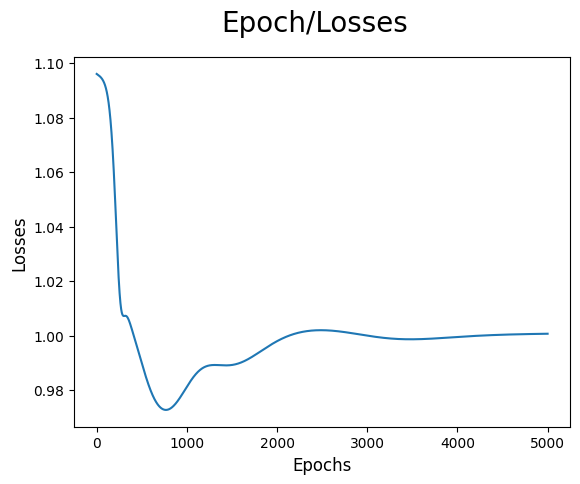

In [66]:
ix = np.arange(0,5000)
fig = plt.figure()
fig.suptitle('Epoch/Losses', fontsize=20)
plt.plot(ix,[costs[i] for i in ix])
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Losses', fontsize=12)

In [67]:
# test
x_test = np.arange(vocab_size)
x_test = np.expand_dims(x_test, axis=0)
softmax_test, _ = forward(x_test, params)
top_sorted_inds = np.argsort(softmax_test, axis=0)[-4:,:]

for input_ind in range(vocab_size):
 input_word = id_to_word[input_ind]
 output_words = [id_to_word[output_ind] for output_ind in top_sorted_inds[::-1,
 input_ind]]
 print("{}'s skip-grams: {}".format(input_word, output_words))


صادق's skip-grams: ['الحكومة', 'مجلس', 'صادق']
مجلس's skip-grams: ['الحكومة', 'مجلس', 'صادق']
الحكومة's skip-grams: ['مجلس', 'صادق', 'الحكومة']


## Apply Glove and FastText

## *Glove*

In [68]:
# code for Glove word embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [149]:
# create the dict.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokens)
# number of unique words in dict.
print("Number of unique words in dictionary=",
len(tokenizer.word_index))
print("Dictionary is = ", tokenizer.word_index)


Number of unique words in dictionary= 3
Dictionary is =  {'صادق': 1, 'مجلس': 2, 'الحكومة': 3}


In [150]:
def embedding_for_vocab(filepath, word_index,
embedding_dim):
    vocab_size = len(word_index) + 1
    # Adding again 1 because of reserved 0 index
    embedding_matrix_vocab = np.zeros((vocab_size,embedding_dim))
    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix_vocab[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix_vocab

In [ ]:
# matrix for vocab: word_index
embedding_dim = 50
embedding_matrix_vocab = embedding_for_vocab( '../glove.6B.50d.txt', tokenizer.word_index,embedding_dim)
print("Dense vector for first word is => ",embedding_matrix_vocab[1])

## *FastText*

In [73]:
# Train FastText model on the filtered words
model = FastText(sentences=[filtered_words], min_count=1)

In [74]:
# Function to get word vector
def get_word_vector(word):
    # Check if word exists in vocabulary
    if word in model.wv.key_to_index:
        return model.wv[word]
    else:
        char_vectors = [model.wv[char] for char in word]
        return sum(char_vectors) / len(char_vectors)

In [75]:
# Example usage
word = "ملك" 
word_vector = get_word_vector(word)
print("Word vector for", word, ":", word_vector)

# Find similar words
similar_words = model.wv.most_similar(positive=[word], topn=2)
print("Similar words to", word, ":", similar_words)

Word vector for ملك : [ 2.4939426e-03 -2.6530840e-03 -3.6038912e-03 -3.6265329e-04
  6.5002480e-04 -4.9164179e-03 -1.5150233e-03 -4.3532033e-03
  2.8854678e-04  9.0320158e-04 -5.0643674e-04  1.3549083e-04
  1.5040238e-04 -5.8105943e-04 -7.0038205e-04  4.4527851e-04
  4.3783477e-04  9.7854447e-04 -7.5154663e-03 -2.7369682e-03
 -6.3122320e-03 -3.6261871e-03  7.5176917e-03  2.2035348e-03
  2.6755694e-03 -5.5503024e-04 -5.2200556e-03  1.9295448e-03
 -2.3634462e-03  1.7909892e-04  3.2443993e-03  8.0840196e-05
  5.7539172e-03 -1.1255129e-03  3.6692740e-03 -2.4360113e-03
  4.0101949e-03  2.1634339e-03  6.4033126e-03 -2.2938780e-03
  3.8403540e-03 -1.0488619e-03  2.2737165e-03  9.7128033e-04
 -2.8554171e-03 -1.6967769e-03  2.5394154e-03 -3.1304916e-03
  3.3743565e-03  5.2769254e-03  1.4840370e-03  7.9794554e-05
  1.7530675e-03  2.8209009e-03 -1.3538431e-03  1.7368438e-04
  3.7753331e-03 -4.1076723e-03  1.5308320e-03 -3.8232959e-03
  8.7837334e-04  4.6686808e-04  7.3828469e-03 -8.1020743e-03
  

# Apply t-SNE to each vectorization method

In [85]:
# One-Hot Encoding
one_hot_encoded = OneHotEncoder(filtered_sen[0])
one_hot_matrix = np.array(one_hot_encoded)

# BoW (Bag-of-Words)
bow_matrix = BOW.toarray()

# TF-IDF
tfidf_matrix = tfidf_matrix.toarray()

# FastText
fasttext_matrix = np.array([model.wv[token] for token in custom_tokens])


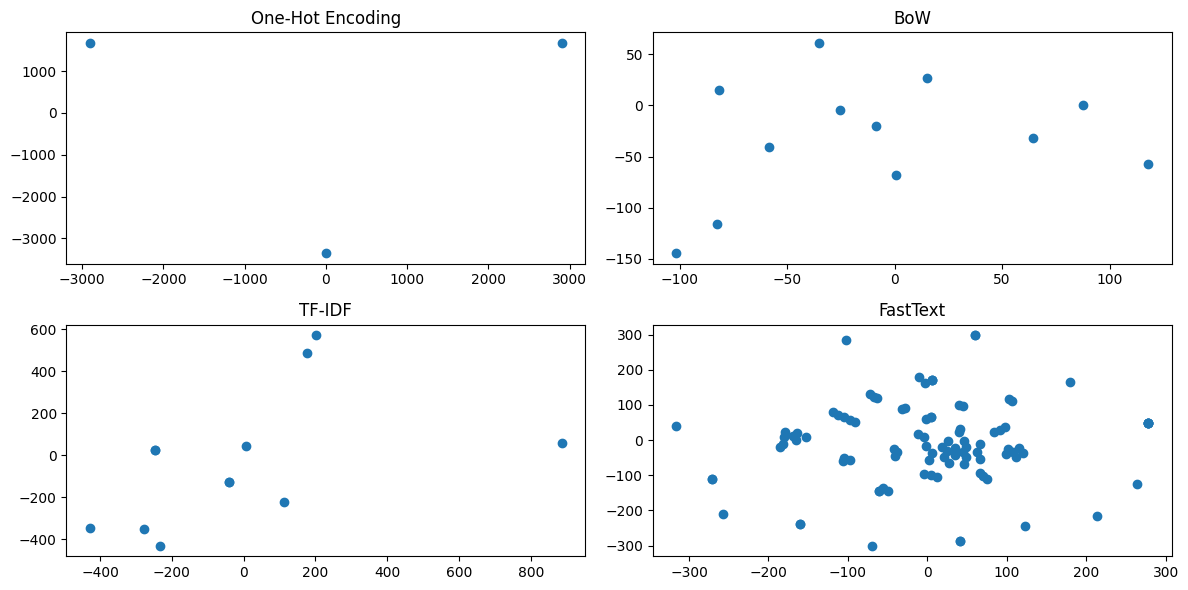

In [86]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
tsne = TSNE(n_components=2, random_state=42,perplexity = 1)
one_hot_tsne = tsne.fit_transform(one_hot_matrix)
plt.scatter(one_hot_tsne[:, 0], one_hot_tsne[:, 1])
plt.title("One-Hot Encoding")

plt.subplot(2, 2, 2)
bow_tsne = tsne.fit_transform(bow_matrix)
plt.scatter(bow_tsne[:, 0], bow_tsne[:, 1])
plt.title("BoW")

plt.subplot(2, 2, 3)
tfidf_tsne = tsne.fit_transform(tfidf_matrix)
plt.scatter(tfidf_tsne[:, 0], tfidf_tsne[:, 1])
plt.title("TF-IDF")

plt.subplot(2, 2, 4)
fasttext_tsne = tsne.fit_transform(fasttext_matrix)
plt.scatter(fasttext_tsne[:, 0], fasttext_tsne[:, 1])
plt.title("FastText")

plt.tight_layout()
plt.show()
